final version --> less features again

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../data_lake/output/val_eng.pkl")

In [4]:
df = df.drop(columns=['card1', 'card2', 'card3','card5', 'addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4','id_32','num_transaction_per_time',
       'multi_transaction_per_time','card6',
       'R_emaildomain'])

In [5]:
val = val.drop(columns=['card1', 'card2', 'card3','card5', 'addr1', 'addr2','id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29','id_35', 'id_36', 'id_37', 'id_38','id_34','M4','id_32','num_transaction_per_time',
       'multi_transaction_per_time','card6',
       'R_emaildomain'])

# 2.0 Training baseline

In [6]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [7]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [8]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [9]:
parameters = {'model__max_depth':[2,4],'model__n_estimators':[100,200,400],'model__learning_rate':[0.05,0.5,0.1]}

In [10]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.74544238 0.75702827 0.76932025 0.78763335 0.80125423 0.81296455
 0.79116322 0.80823009 0.80984969 0.85930779 0.87014542 0.87014542
 0.75794191 0.77114745 0.78294083 0.80054822 0.81761546 0.8385864 ]

Mean CV Scores: 
[0.74087485 0.74996901 0.75968526 0.77152027 0.77874529 0.7875912
 0.77064764 0.78098893 0.78211007 0.81325536 0.81662021 0.81662021
 0.75158779 0.7606814  0.7686548  0.77949292 0.78995829 0.80191805]

Best Parameters: 
{'model__learning_rate': 0.5, 'model__max_depth': 4, 'model__n_estimators': 200}



# 3.0 Evaluation baseline

In [11]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [12]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [13]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8221820373719108
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     19976
         1.0       0.29      0.82      0.42      1659

    accuracy                           0.83     21635
   macro avg       0.63      0.83      0.66     21635
weighted avg       0.93      0.83      0.86     21635

ProductCD: 0.38860134750610525
TransactionAmt: 0.1320056388169184
card4: 0.11571058373291007
id_30: 0.037184265661583775
id_33: 0.020107795707140254
DeviceType: 0.011848506381294989
max_c: 0.009876415669560677
device_info_v4: 0.0021688198102364554
browser_enc: 0.0020011237810310966
max_d: 0.0007142535748875719
P_emaildomain: 7.183270907362746e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d'], dtype='object')),
                                                 ('categorical_preproce

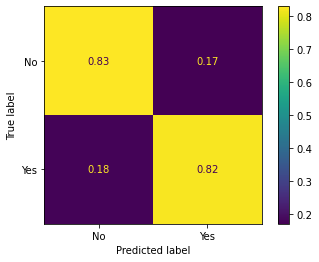

In [14]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)

In [15]:
df.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,P_emaildomain,id_30,id_33,DeviceType,max_c,max_d,browser_enc,device_info_v4
17544,1,41.102,C,visa,anonymous.com,nan,nan,mobile,4079.0,257.0,safari,other
139763,0,150.000,R,mastercard,anonymous.com,Windows_10,1366x768,desktop,1.0,0.0,chrome,windows
107175,1,29.183,C,visa,gmail.com,nan,nan,mobile,91.0,99.0,chrome,samsung


# 4.0 Model Output

In [15]:
with open('../../data_lake/output/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.base_estimator, file)